# Test reader group validity
Are the labels based on expert and location status that we assigned to readers actually valid?

We'll look at some example previous comments from readers to figure this out.

In [2]:
## load question data
import pandas as pd
question_data = pd.read_csv('../../data/reddit_data/advice_subreddit_filter_comment_question_data.gz', sep='\t', index_col=False, usecols=['author', 'id', 'parent_id', 'created_utc', 'question'])

In [25]:
from datetime import datetime
author_data = pd.read_csv('../../data/reddit_data/author_data/combined_author_prior_comment_data.gz', sep='\t', index_col=False, usecols=['author', 'date_day', 'subreddit', 'expert_pct', 'expert_pct_bin', 'subreddit_country', 'location_region', 'date_day_bin'], converters={'date_day' : lambda x: datetime.strptime(x, '%Y-%m-%d') if x!='' else None})
display(author_data.head())

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,author,date_day,subreddit,expert_pct,expert_pct_bin,subreddit_country,location_region,date_day_bin
0,Beetleguise78,2018-10-05,personalfinance,0.000000,0.0,UNK,UNK,2018-07-01
1,IdaAreIda,2019-01-23,AmItheAsshole,0.200000,1.0,dk,NONUS,2019-01-01
2,talosguideu,2019-06-05,Advice,0.010000,0.0,UNK,UNK,2019-01-01
3,talosguideu,2019-03-02,Advice,0.010101,0.0,UNK,UNK,2019-01-01
4,talosguideu,2019-03-30,Advice,0.010000,0.0,UNK,UNK,2019-01-01


Let's take a sample of authors for each reader group and look at their previous posts to determine if they deserve to be labelled the way that they are.

In [44]:
import numpy as np
np.random.seed(456)
group_vars = ['expert_pct_bin', 'location_region']
sample_author_data = []
sample_size = 100
for group_var_i in group_vars:
    for (subreddit_j, group_val_j), data_j in author_data.drop_duplicates('author').groupby(['subreddit', group_var_i]):
        if(group_val_j != 'UNK'):
            sample_data_j = data_j.loc[np.random.choice(data_j.index, sample_size, replace=False)]
            sample_data_j = sample_data_j.assign(**{'reader_group' : group_var_i})
            sample_author_data.append(sample_data_j)
sample_author_data = pd.concat(sample_author_data, axis=0)
print(sample_author_data.shape)

(2000, 9)


### Validity check: expert status

Check expert status first: what are the top-K subreddits for each author prior to post?

In [49]:
import os
from datetime import datetime
def collect_author_data(author_name, data_dir):
    author_data_file = os.path.join(data_dir, f'{author_name}_comments.gz')
    author_data = pd.read_csv(author_data_file, sep='\t', compression='gzip', index_col=False, usecols=['author', 'subreddit', 'created_utc', 'id', 'body'], converters={'created_utc' : lambda x: datetime.fromtimestamp(int(float(x)))})
    return author_data
author_data_dir = '../../data/reddit_data/author_data/'
author_prior_post_data = pd.concat(list(map(lambda x: collect_author_data(x, author_data_dir), sample_author_data.loc[:, 'author'].unique())), axis=0)
print(author_prior_post_data.shape[0])

163694


In [38]:
# get subreddit neighbors => compute expert status
from ast import literal_eval
subreddit_neighbor_data = pd.read_csv('../../data/reddit_data/author_data/advice_subreddit_neighbors.tsv', sep='\t', index_col=False, converters={'neighbors' : literal_eval})
# convert to dict for lookup
subreddit_neighbor_lookup = dict(zip(subreddit_neighbor_data.loc[:, 'subreddit'].values, subreddit_neighbor_data.loc[:, 'neighbors'].values))
display(subreddit_neighbor_lookup)

{'Advice': {'AskDocs',
  'answers',
  'ask',
  'dating_advice',
  'getdisciplined',
  'mentalhealth',
  'needadvice',
  'socialskills',
  'tipofmytongue'},
 'AmItheAsshole': {'AskDocs', 'IsItBullshit', 'TooAfraidToAsk'},
 'legaladvice': {'AskHR',
  'Insurance',
  'Landlord',
  'LawSchool',
  'LegalAdviceUK',
  'Scams',
  'bestoflegaladvice'},
 'pcmasterrace': {'Monitors',
  'SuggestALaptop',
  'bapcsalescanada',
  'buildmeapc',
  'linuxmasterrace',
  'overclocking',
  'pcgaming',
  'watercooling'},
 'personalfinance': {'Accounting',
  'CreditCards',
  'FinancialPlanning',
  'RealEstate',
  'StudentLoans',
  'askcarsales',
  'churning',
  'financialindependence',
  'investing',
  'smallbusiness',
  'tax',
  'whatcarshouldIbuy',
  'ynab'}}

In [46]:
expert_pct_bins = [0., 1.]
expert_sample_author_data = sample_author_data[sample_author_data.loc[:, 'reader_group']=='expert_pct_bin']
expert_sample_author_prior_subreddit_post_pct = []
for subreddit_i, data_i in sample_author_data.groupby(['subreddit']):
    expert_subreddits_i = [subreddit_i] + list(subreddit_neighbor_lookup[subreddit_i])
    for idx_j, data_j in data_i.iterrows():
        author_j = data_j.loc['author']
        date_j = data_j.loc['date_day']
        expert_bin_j = data_j.loc['expert_pct_bin']
        author_prior_post_data_j = author_prior_post_data[(author_prior_post_data.loc[:, 'author']==author_j) &
                                                          (author_prior_post_data.loc[:, 'created_utc']<date_j)]
        # what % of prior posts were in expert subreddits?
        subreddit_pct_j = author_prior_post_data_j.loc[:, 'subreddit'].value_counts() / author_prior_post_data_j.shape[0]
        expert_subreddit_j = set(expert_subreddits_i) & set(subreddit_pct_j.index)
        if(len(expert_subreddit_j) > 0):
            expert_subreddit_pct_j = subreddit_pct_j.loc[expert_subreddit_j].sum()
        else:
            expert_subreddit_pct_j = 0.
        expert_sample_author_prior_subreddit_post_pct.append([author_j, date_j, subreddit_i, expert_subreddit_pct_j, expert_bin_j])
expert_sample_author_prior_subreddit_post_pct = pd.DataFrame(expert_sample_author_prior_subreddit_post_pct, columns=['author', 'date_day', 'subreddit', 'expert_subreddit_pct', 'expert_pct_bin'])

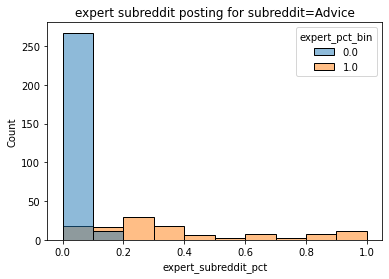

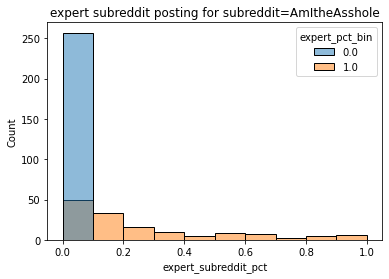

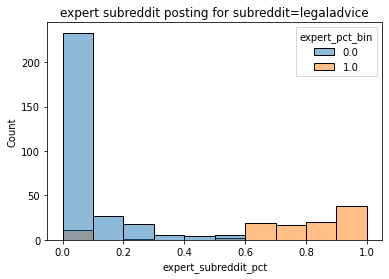

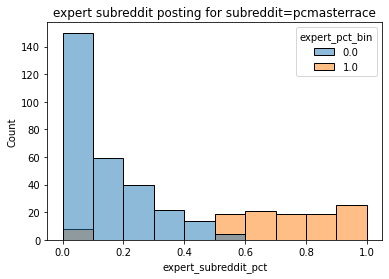

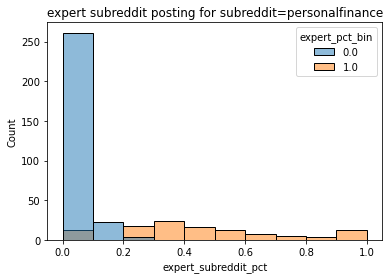

In [48]:
## plot distribution of prior subreddit posting by expert type
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
for subreddit_i, data_i in expert_sample_author_prior_subreddit_post_pct.groupby('subreddit'):
    sns.histplot(data=data_i, x='expert_subreddit_pct', hue='expert_pct_bin', bins=10)
    plt.title(f'expert subreddit posting for subreddit={subreddit_i}')
    plt.show()

OK! Except for a few outliers, we generally see that authors classified as "expert" do post more frequently in designated "expert" subreddits than non-experts.

### Validity check: location

Now let's check for whether authors who were labelled as "US" or "non-US" should be labelled based on (1) self-identification (2) posting in location-specific subreddits.

In [61]:
location_sample_author_data = sample_author_data[sample_author_data.loc[:, 'reader_group']=='location_region']
## look for self-identification
import data_helpers
from importlib import reload
reload(data_helpers)
from data_helpers import full_location_pipeline
from stanza import Pipeline
from tqdm import tqdm
from nltk.tokenize import PunktSentenceTokenizer
import re
sent_tokenizer = PunktSentenceTokenizer()
nlp_pipeline = Pipeline(lang='en', processors='tokenize,ner', use_gpu=False)
location_matcher = re.compile('(?<=i\'m from )[a-z0-9\, ]+|(?<=i am from )[a-z0-9\, ]+|(?<=i live in )[a-z0-9\, ]+')
# get self-ID location first because it's harder lol
author_self_id_location = []
for author_i, data_i in tqdm(location_sample_author_data.groupby('author')):
    prior_post_data_i = author_prior_post_data[author_prior_post_data.loc[:, 'author']==author_i]
    post_text_i = prior_post_data_i.loc[:, 'body'].values
    loc_i, loc_country_i = full_location_pipeline(post_text_i, location_matcher, sent_tokenizer, nlp_pipeline, return_raw_locations=True)
    author_self_id_location.append([author_i, loc_i, loc_country_i])
author_self_id_location = pd.DataFrame(author_self_id_location, columns=['author', 'self_ID_location_list', 'self_ID_location_country'])

2021-06-22 03:48:45 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2021-06-22 03:48:45 INFO: Use device: cpu
2021-06-22 03:48:45 INFO: Loading: tokenize
2021-06-22 03:48:45 INFO: Loading: ner
2021-06-22 03:48:46 INFO: Done loading processors!
100%|██████████| 1000/1000 [02:28<00:00,  6.74it/s]


In [65]:
display(author_self_id_location[author_self_id_location.loc[:, 'self_ID_location_country']!='UNK'].head(20))
print(author_self_id_location.loc[:, 'self_ID_location_country'].value_counts())

,author,self_ID_location_list,self_ID_location_country
0,-Slavsky-,[cali],co
8,365Blistering,[us],us
17,ATallShip,"[minnesota, wisconsin]",us
22,AdorableStrategy,[nyc],us
30,ApoIIoCreed,[denver],us
32,Aranore,[canada],ca
35,ArizonaRenegade,"[arizona, phoenix, phoenix]",us
38,Ask_Me_About_The_NAP,[ms],us
40,AssertiveCollective,[seattle],us
41,AtomicLummox,"[huntingdon, alconbury]",gb


UNK    809
us     106
ca      19
gb      12
nl       9
de       7
au       5
fr       5
se       3
co       3
kr       2
be       2
it       2
az       2
nz       2
dk       1
ie       1
za       1
in       1
br       1
cu       1
sa       1
fi       1
ph       1
es       1
bg       1
ga       1
Name: self_ID_location_country, dtype: int64


OK! So the locations identified by the `NER` pipeline actually do match the self-declared locations, although the coverage isn't great (~20% total).

What about the subreddit locations?

In [73]:
from ast import literal_eval
subreddit_location_data = pd.read_csv('../../data/reddit_data/author_data/subreddit_location_data.gz', sep='\t', compression='gzip', index_col=False, converters={'location_data' : literal_eval})
# filter by confidence FML
subreddit_location_data = subreddit_location_data.assign(**{
    'confidence' : subreddit_location_data.loc[:, 'location_data'].apply(lambda x: x['features'][0]['properties']['accuracy'])
})
display(subreddit_location_data.head())

,subreddit,clean_subreddit,location_data,country,country_region,confidence
0,politics,politics,"{'type': 'FeatureCollection', 'features': [{'t...",ph,non_US,0.101
1,Advice,Advice,"{'type': 'FeatureCollection', 'features': [{'t...",ar,non_US,0.111
2,funny,funny,"{'type': 'FeatureCollection', 'features': [{'t...",de,non_US,0.101
3,news,news,"{'type': 'FeatureCollection', 'features': [{'t...",ca,non_US,0.300
4,pics,pics,"{'type': 'FeatureCollection', 'features': [{'t...",it,non_US,0.225


In [79]:
accuracy_cutoff = 0.80
high_accuracy_subreddit_location_data = subreddit_location_data[subreddit_location_data.loc[:, 'confidence']>=accuracy_cutoff]
display(high_accuracy_subreddit_location_data.head(10))
location_subreddit_names = set(high_accuracy_subreddit_location_data.loc[:, 'subreddit'].unique())

,subreddit,clean_subreddit,location_data,country,country_region,confidence
56,canada,canada,"{'type': 'FeatureCollection', 'features': [{'t...",ca,non_US,0.966126
69,europe,europe,"{'type': 'FeatureCollection', 'features': [{'t...",eur,non_US,0.820707
79,australia,australia,"{'type': 'FeatureCollection', 'features': [{'t...",au,non_US,0.952135
81,de,de,"{'type': 'FeatureCollection', 'features': [{'t...",de,non_US,0.989681
112,ireland,ireland,"{'type': 'FeatureCollection', 'features': [{'t...",ie,non_US,0.873846
121,nyc,nyc,"{'type': 'FeatureCollection', 'features': [{'t...",us,US,0.817577
124,chicago,chicago,"{'type': 'FeatureCollection', 'features': [{'t...",us,US,0.851530
138,LosAngeles,Los Angeles,"{'type': 'FeatureCollection', 'features': [{'t...",us,US,0.973805
140,SeattleWA,Seattle WA,"{'type': 'FeatureCollection', 'features': [{'t...",us,US,0.882979
150,boston,boston,"{'type': 'FeatureCollection', 'features': [{'t...",us,US,0.810251


How often do people post in one of these subreddits, and how often is one subreddit location dominant over others?

In [102]:
author_prior_post_data.loc[:, 'author'].value_counts().reset_index(name='count')

,index,count
0,SmaugTheGoldenDragon,100
1,Bihema,100
2,ApoIIoCreed,100
3,Cheesysocks,100
4,thebenson,100
...,...,...
1856,WorldlyCorner,1
1857,brdycl,1
1858,StevieBtheKitty,1
1859,HARLEYRIDER1996,1


In [99]:
author_prior_post_data.groupby('author').apply(lambda x: x.loc[:, 'subreddit'].value_counts()).reset_index().rename(columns={'level_1':'subreddit', 'subreddit' : 'subreddit_count'}).head()

,author,subreddit,subreddit_count
0,477536,Advice,30
1,477536,fountainpens,11
2,477536,aww,9
3,477536,pics,7
4,477536,Assistance,5


In [91]:
author_location_subreddit_data = []
for author_i, data_i in location_sample_author_data.groupby('author'):
    prior_post_data_i = author_prior_post_data[author_prior_post_data.loc[:, 'author']==author_i]
    subreddit_counts_i = prior_post_data_i.loc[:, 'subreddit'].value_counts()
    location_subreddits_i = set(subreddit_counts_i.index) & location_subreddit_names
    if(len(location_subreddits_i) > 0):
        location_subreddit_total_i = subreddit_counts_i.loc[location_subreddits_i].sum()
        location_subreddit_max_pct_i = subreddit_counts_i.loc[location_subreddits_i].max() / location_subreddit_total_i
        location_subreddit_max_i = subreddit_counts_i.loc[location_subreddits_i].sort_values(inplace=False, ascending=False).index[0]
        author_location_subreddit_data.append([author_i, location_subreddit_total_i, location_subreddit_max_pct_i, location_subreddit_max_i])
author_location_subreddit_data = pd.DataFrame(author_location_subreddit_data, columns=['author', 'location_subreddit_total', 'location_subreddit_max_pct', 'max_location_subreddit'])
author_location_subreddit_data.sort_values('location_subreddit_total', inplace=True, ascending=False)
display(author_location_subreddit_data.head(10))
display(author_location_subreddit_data.tail(10))

,author,location_subreddit_total,location_subreddit_max_pct,max_location_subreddit
243,Odatas,80,0.962500,de
118,FruityLexperia,76,1.000000,australia
725,yosoyelgerman,75,1.000000,uruguay
179,LANCafeMan,75,0.986667,korea
592,nynikai,74,1.000000,ireland
240,NotFallacyBuffet,69,1.000000,NewOrleans
128,Guinness,66,1.000000,chicago
576,n1c0_ds,63,0.634921,berlin
47,Boredbarista,61,1.000000,SeattleWA
508,im-so-curious,58,1.000000,malaysia


,author,location_subreddit_total,location_subreddit_max_pct,max_location_subreddit
331,Throwawaygrowerauto,1,1.0,europe
347,Whiteguy1x,1,1.0,missouri
343,WastaSpace,1,1.0,SeattleWA
341,UrFrickinGirl,1,1.0,europe
339,UFO-no,1,1.0,chicago
337,Traveler1983,1,1.0,SeattleWA
335,TopGinger,1,1.0,europe
334,ToldHerWhatTimeItWas,1,1.0,Michigan
332,TigerMeltz,1,1.0,philadelphia
727,ze_calculator,1,1.0,boston


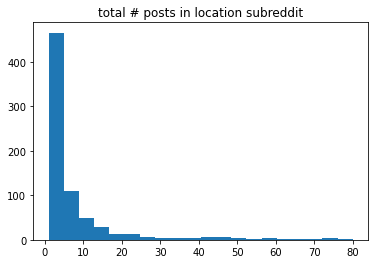

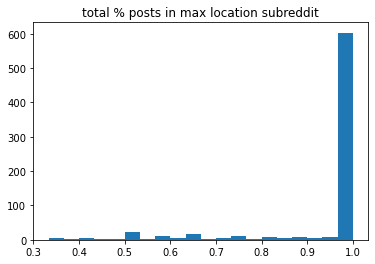

In [95]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(author_location_subreddit_data.loc[:, 'location_subreddit_total'], bins=20)
plt.title('total # posts in location subreddit')
plt.show()
plt.hist(author_location_subreddit_data.loc[:, 'location_subreddit_max_pct'], bins=20)
plt.title('total % posts in max location subreddit')
plt.show()

Most people post very few times in a location subreddit, but they also tend to post consistently in a single "dominant" location subreddit.